<a href="https://colab.research.google.com/github/justin-hsieh/DS-Unit-2-Kaggle-Challenge/blob/master/assignment_kaggle_challenge_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science, Unit 2: Predictive Modeling

# Kaggle Challenge, Module 1

## Assignment
- [x] Do train/validate/test split with the Tanzania Waterpumps data.
- [x] Define a function to wrangle train, validate, and test sets in the same way. Clean outliers and engineer features. (For example, [what other columns have zeros and shouldn't?](https://github.com/Quartz/bad-data-guide#zeros-replace-missing-values) What other columns are duplicates, or nearly duplicates? Can you extract the year from date_recorded? Can you engineer new features, such as the number of years from waterpump construction to waterpump inspection?)
- [x] Select features. Use a scikit-learn pipeline to encode categoricals, impute missing values, and fit a decision tree classifier.
- [x] Get your validation accuracy score.
- [x] Get and plot your feature importances.
- [x] Submit your predictions to our Kaggle competition. (Go to our Kaggle InClass competition webpage. Use the blue **Submit Predictions** button to upload your CSV file. Or you can use the Kaggle API to submit your predictions.)
- [x] Commit your notebook to your fork of the GitHub repo.


## Stretch Goals

### Reading

- A Visual Introduction to Machine Learning
  - [Part 1: A Decision Tree](http://www.r2d3.us/visual-intro-to-machine-learning-part-1/)
  - [Part 2: Bias and Variance](http://www.r2d3.us/visual-intro-to-machine-learning-part-2/)
- [Decision Trees: Advantages & Disadvantages](https://christophm.github.io/interpretable-ml-book/tree.html#advantages-2)
- [How a Russian mathematician constructed a decision tree — by hand — to solve a medical problem](http://fastml.com/how-a-russian-mathematician-constructed-a-decision-tree-by-hand-to-solve-a-medical-problem/)
- [How decision trees work](https://brohrer.github.io/how_decision_trees_work.html)
- [Let’s Write a Decision Tree Classifier from Scratch](https://www.youtube.com/watch?v=LDRbO9a6XPU) — _Don’t worry about understanding the code, just get introduced to the concepts. This 10 minute video has excellent diagrams and explanations._
- [Random Forests for Complete Beginners: The definitive guide to Random Forests and Decision Trees](https://victorzhou.com/blog/intro-to-random-forests/)


### Doing
- [ ] Add your own stretch goal(s) !
- [ ] Try other [scikit-learn imputers](https://scikit-learn.org/stable/modules/impute.html).
- [ ] Try other [scikit-learn scalers](https://scikit-learn.org/stable/modules/preprocessing.html).
- [ ] Make exploratory visualizations and share on Slack.


#### Exploratory visualizations

Visualize the relationships between feature(s) and target. I recommend you do this with your training set, after splitting your data. 

For this problem, you may want to create a new column to represent the target as a number, 0 or 1. For example:

```python
train['functional'] = (train['status_group']=='functional').astype(int)
```



You can try [Seaborn "Categorical estimate" plots](https://seaborn.pydata.org/tutorial/categorical.html) for features with reasonably few unique values. (With too many unique values, the plot is unreadable.)

- Categorical features. (If there are too many unique values, you can replace less frequent values with "OTHER.")
- Numeric features. (If there are too many unique values, you can [bin with pandas cut / qcut functions](https://pandas.pydata.org/pandas-docs/stable/getting_started/basics.html?highlight=qcut#discretization-and-quantiling).)

You can try [Seaborn linear model plots](https://seaborn.pydata.org/tutorial/regression.html) with numeric features. For this problem, you may want to use the parameter `logistic=True`

You do _not_ need to use Seaborn, but it's nice because it includes confidence intervals to visualize uncertainty.

#### High-cardinality categoricals

This code from a previous assignment demonstrates how to replace less frequent values with 'OTHER'

```python
# Reduce cardinality for NEIGHBORHOOD feature ...

# Get a list of the top 10 neighborhoods
top10 = train['NEIGHBORHOOD'].value_counts()[:10].index

# At locations where the neighborhood is NOT in the top 10,
# replace the neighborhood with 'OTHER'
train.loc[~train['NEIGHBORHOOD'].isin(top10), 'NEIGHBORHOOD'] = 'OTHER'
test.loc[~test['NEIGHBORHOOD'].isin(top10), 'NEIGHBORHOOD'] = 'OTHER'
```



In [0]:
# If you're in Colab...
import os, sys
in_colab = 'google.colab' in sys.modules

if in_colab:
    # Install required python packages:
    # category_encoders, version >= 2.0
    # pandas-profiling, version >= 2.0
    # plotly, version >= 4.0
    !pip install --upgrade category_encoders pandas-profiling plotly
    
    # Pull files from Github repo
    os.chdir('/content')
    !git init .
    !git remote add origin https://github.com/LambdaSchool/DS-Unit-2-Kaggle-Challenge.git
    !git pull origin master
    
    # Change into directory for module
    os.chdir('module1')

In [2]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import category_encoders as ce
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from scipy import stats
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import DecisionTreeClassifier

train = pd.merge(pd.read_csv('../data/tanzania/train_features.csv'), 
                 pd.read_csv('../data/tanzania/train_labels.csv'))
test = pd.read_csv('../data/tanzania/test_features.csv')
sample_submission = pd.read_csv('../data/tanzania/sample_submission.csv')

train.shape, test.shape

((59400, 41), (14358, 40))

In [3]:

train, val = train_test_split(train, train_size=0.80, test_size=0.20,
                              stratify= train['status_group'], random_state=42)

train.shape, val.shape, test.shape
train['date_recorded'].min()
         

'2002-10-14'

In [0]:
train['construction_year'].value_counts()

In [0]:
def wrangle(df):

    df = df.copy()

    df['latitude'] = df['latitude'].replace(-2e-08, 0)

    cols_w_zeros = ['longitude','latitude']
    for col in cols_w_zeros:
        df[col] = df[col].replace(0, np.nan)
    
    cols_w_nans = ['public_meeting', 'scheme_management', 'permit']
    for col in cols_w_nans:
        df[col] = df[col].replace('nan', stats.mode)
    
    dates = pd.to_datetime(df['date_recorded'])

    df = df.drop(columns='quantity_group')

    return df


In [0]:
train = wrangle(train)
val = wrangle(val)
test = wrangle(test)

target = 'status_group'
train_features = train.drop(columns=[target, 'id'])

numeric_features = train_features.select_dtypes('number').columns.tolist()

cardinality = train_features.select_dtypes(exclude='number').nunique()
categorical_features = cardinality[cardinality <=50].index.tolist()

features = numeric_features + categorical_features

X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]
X_test = test[features]


In [7]:
pipeline = make_pipeline(
    ce.OneHotEncoder(use_cat_names=True),
    SimpleImputer(),
    StandardScaler(),
    DecisionTreeClassifier(max_depth=20,random_state=42)
    #LogisticRegression(solver='lbfgs', multi_class='auto', max_iter=5000)
)

pipeline.fit(X_train, y_train)

print(pipeline.score(X_val, y_val))

prediction = pipeline.predict(X_test)

#submission = sample_submission.copy()
#submission['status_group'] = prediction
#submission.to_csv('submission-02.csv', index=False)

0.7744949494949495


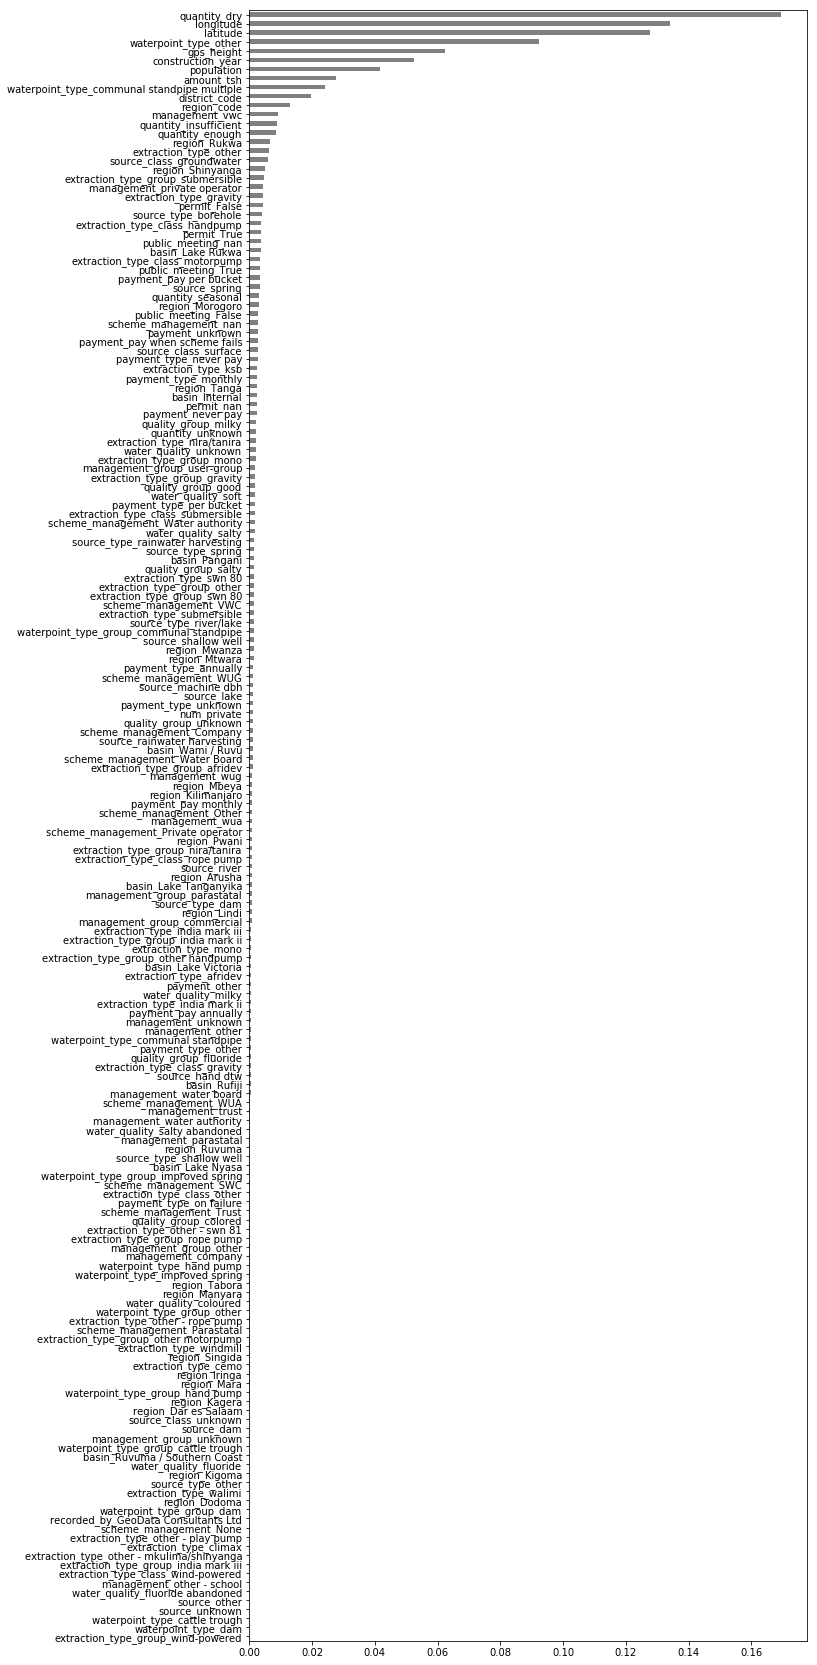

In [12]:
pipeline.named_steps
model = pipeline.named_steps['decisiontreeclassifier']
#model.coef_
encoder = pipeline.named_steps['onehotencoder']
encoded_columns = encoder.fit_transform(X_train).columns
importances = pd.Series(model.feature_importances_, encoded_columns)
plt.figure(figsize=(10,30))
importances.sort_values().plot.barh(color='grey');